In [278]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 1000
intermediate_dim = 512
latent_dim = 2
batch_size = 100
epochs = 100
epsilon_std = 1.0


In [279]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [280]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


In [281]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split


In [282]:
def splitw(x):
    return np.array([y for y in x])
#.replace('T','1'),replace('G','2').replace('C','3')

In [283]:
FILES=glob.glob('../hwdata/hiv/*seq')
! wc ../hwdata/hiv/*seq

     61      60  550167 ../hwdata/hiv/hiv-db-LTNP.seq
     38      37  341344 ../hwdata/hiv/hiv-db-SP.seq
     24      23  205225 ../hwdata/hiv/hiv-db-zP.seq
     39      38  344731 ../hwdata/hiv/hiv-db-zRP.seq
    162     158 1441467 total


In [284]:
data=pd.concat([pd.read_csv(i,header=None) for i in FILES])

data1=np.array([x1 for x1 in np.squeeze(data)])

data2=np.array([splitw(x1.replace('A','1').replace('T','2').replace('G','3').replace('C','4')).astype(int) for x1 in data1])

data2.shape

(158,)

In [285]:
X=[]
dim1=158
for i in data2:
    X=np.append(X,i[:original_dim])
X=X.reshape(dim1,int(original_dim))
X=X/4.

In [286]:
y=np.array([0*np.ones(60),1*np.ones(37),2*np.ones(23),3*np.ones(38)])
y=np.squeeze(y)
YY=[]
for i in y:
    YY=np.append(YY,i)
YY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.])

In [287]:
x_train, x_test, y_train,  y_test=train_test_split(X,YY,test_size=.2)

In [288]:
x_test.shape

(32, 1000)

In [289]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

Train on 126 samples, validate on 32 samples
Epoch 1/100
126/126 [==============================] - 0s 3ms/step - loss: 764.5910 - val_loss: 695.2400
Epoch 2/100
126/126 [==============================] - 0s 184us/step - loss: 694.7413 - val_loss: 691.3505
Epoch 3/100
126/126 [==============================] - 0s 164us/step - loss: 690.1971 - val_loss: 685.0285
Epoch 4/100
126/126 [==============================] - 0s 177us/step - loss: 684.4441 - val_loss: 685.5449
Epoch 5/100
126/126 [==============================] - 0s 178us/step - loss: 685.2478 - val_loss: 681.4565
Epoch 6/100
126/126 [==============================] - 0s 165us/step - loss: 680.1861 - val_loss: 680.7792
Epoch 7/100
126/126 [==============================] - 0s 161us/step - loss: 680.7606 - val_loss: 682.3705
Epoch 8/100
126/126 [==============================] - 0s 164us/step - loss: 681.3193 - val_loss: 680.5606
Epoch 9/100
126/126 [==============================] - 0s 162us/step - loss: 680.0096 - val_loss: 678

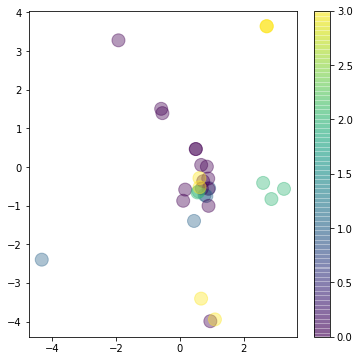

In [290]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=13**2, cmap='viridis')
plt.colorbar()


In [301]:
val=[-1,3]

In [302]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

'CGGTTATCTTGTGTGCCCTGTGATCGTTTTGTCTGTGTTGAATATGTCGTGCAGTGGCTCGCGTTGATGGACTTTAATGCGAATGTTTGTCCTGTGTTGATCTCGCGACTCTGGAGTGGTGTTGCTGATTTGGACTCGGGTTGTGGCGTGTGCGGGGGGTGTTGTGTTCGCCTAATTTTTTTTGTCTTGCGGTGGCTAGAAGGTGATATATGGGTGGGAGTGCGTCTTTATTATGAGTCTTAATTTTTGTGTGCGGTGAAAGAATTTAGTTTAATGGTTTGTCAAATATTTTGTATATTATGAAAGTCCTTGGCTTTTGAATCTGTTATGTGTTAATTTTTGGTGTTTTCCGTGGGCTTTTTGTGAGATGTTTTGTCTGTATTCTGTGGGTTGATGAACTACATGGTGGTCTTGAGAGAGTATGAAAGTTGTTGTTTGGTGTTTAGATGTGTGTTGGTAGTGTCTTTTTTGTTGATTTAATTTTTGAGGTACTGGTGAGGTTGGTTTGGTTATTGAATATTAAGGAGTTACTAATCAATTGTGAGGTAAAATGTGTGGAGAGTTAATCTTGTGTCATTTTAAATGTCAGGGTTTATTATCGTTTTTGGGATATTGTTGTTTTTGAAATGGTAGACGTGTGGATTTCGGGTTGTAGTTTTTATGGTTGGGGTTTAGTTTTTGATGATATTGGTGTGTGCGGATAGTTAATTGGCATTTTTTGAGGATGTGGTTATTTAGGCTCGGCAGTAGATGTTAATTGGATGTTTTTTTCTGTTTTGTTGGATGTTGGAGCGTTTGAATTGTTTTTTGTGTGCATTTATGTGGTGGGTTGTTAATTGTTTTGTTGAGATGGTTTGGTTGGTGTGCGTTTTGGTCGTGGCGATTTGTGTGTTCGTTGGGTTTTGGTGTTTGGTTGATGTTGTTTTTCCCTTGTGTATGATTTTGGTGTTTTTTGATTTTTCGGTGGGATGGGTGTTGGATAATTGTATATTTTTGGTA

In [262]:
val=[-2,1]

In [263]:
''.join(np.round(decoder.predict(np.array(val).reshape(1,2))*4)[0].astype(int).astype(str)).replace('1','A').replace('2','T').replace('3','G').replace('4','C')

'GGGTTGTGTTTGTGCCCGTGTGGGTTTTTACGCGTTTAACTTGTTGTGCCTCAGTCGTTAATTTGATTTTTTGTATGGGTGGGGGGTGTTGTGGCGTTGTGTGAGGTTTAATCTTTTTAAATAGGTGTGTTTAGGGCTGTTCGGATTAGAGTTGATTGATTATATCAGAGTGGATGTGCGTTGAGGGTGGTGGTGGGATTGGGGGTATATGGTTTGGGTTGGTTATGGTGTTTTGTGAGATTTCTTTGGGAGTTGCACGTTCTTGCTTGCGGTGATAGATGATGATATGTAGATATTTGTGTTTATTGCACTGTTTTATTGGGGTAATTTGTTGATGGAGATATATAGGTGAATCAGTCGTGTGTATGTATATTCAGTTTACGCTTTCGTGAAATGAAGATGATTATTTATTGAGGTGAATGAGGATCTTCGACATCGATCTCGTGTGACTGGATCTTATTATGGGTTATGTTTTTTGAGCAGTTTTGCGAGTCTCTATTGGTTGCTTTTTGAGTTAGAGCTAGTATTCTGGTTGGAATGCTATTACAAGATATTGGAATTACTTTACAATTTTGAGCTATTTACACAGCAGGGTGATTGGGGGGTGGTGGTGTTCATTGAAATTGTAGGGTTATGTCATATTCTGCATTTGGAGTTGGGAGTGGATGGCTTTTGTGCTTGAACATTGATTTGTGGTTATAATGTTATAGATTTGATGGGGTTGTTCCGTGTGGTATTTCGCTAGTGGAGAGCTTTTTGTGAAGGTGGGTGCGCAGATGATTTAGAGTGGTTTTGGATGTCGTTGTTTTTTCATCTAGGAGGGATTGATTAGGTTTTGGATTGGTATATTTTTTTTTGTGGAGTATTTGGTTGGTTTGATGGATTAGAGTGTGTTGGTTTTGCTCGAGCGGTATTGTGTTAAGGATTGTTTTTGGATATTGGTGGTTGTTGTATTTGGGTTGTGGATGGAATATGAGTGATATGTGGTATCGGTCGTTT

## HW:
---
    1. what are the hyper parameters you can tune?
    2. Tune the models so that the distribution is more compact.
    3. Investigate other segments (POL, ENV, INTEGRASE, Reverse-transcriptase, and complete genome)
    4. Blast it against the origin sequence data to investigate if we are closer to the clinical subtypes that we shpuld be closer to
    5. How well can we actually use this to generate new samples (sequences of hiv clinical subtypes not in the dataset?)